In [37]:
using XLSX
using Plots
using LaTeXStrings
using JLD

include("../src/FCSeqTools.jl");
include("../src/functions.jl");

# SELECT DATA ############################################################################
alignment = "CM_alignment"  #"Betalactamases"  #    
sigla = "(CM)"    #"(BL)"  #                                           
method = "cumulative"
test = "main_test"
stop = 0.9
fraction = 0.3
alphas = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]#, 0.95]
l = length(alphas)
notebooks = [1, 2, 3]
#########################################################################################
q = 21
sigla == "(CM)"  ? L = 96  : L = 222
#########################################################################################
rm(joinpath("figures/"* alignment,"fitness_energy_vs_pseudocout"), force=true, recursive=true)
mkdir(joinpath("figures/"* alignment,"fitness_energy_vs_pseudocout"))
figure_path = joinpath("figures/"* alignment,"fitness_energy_vs_pseudocout");

## Reading Fasta

In [22]:
nat_MSA, nat_re, nat_E = read_fasta("paper_data/nat.faa", 0.2);
gen_MSA, gen_re, gen_E = read_fasta("paper_data/gen.faa", 0.2);
dms_MSA, dms_re, dms_E = read_fasta("paper_data/dms.faa", 0.2);

L_nat = length(nat_MSA[:,1])
L_gen = length(gen_MSA[:,1])
L_dms = length(dms_MSA[:,1]);

wt_seq = nat_MSA[1,:];


In [23]:
# SELECT DATA ############################################################################
alignment = "CM_alignment"   # "Betalactamases"  
sigla =  "(CM)"    # "(BL)"                                         
method = "cumulative"
test = "main_test"
stop = 0.9
fraction = 0.3
alphas = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]#, 0.95]
l = length(alphas)
nbk_vec = [1, 2, 3]
threshold = 0
α_h = 0.01 # initial pseudo count
#########################################################################################
q = 21
sigla == "(CM)"  ? L = 96 : L = 222
sigla == "(CM)"  ? MSA = "CM_130530_MC.fasta" : MSA = "Betalactamases_VIM-NDM.fasta";
#########################################################################################

In [50]:

re_E_pearson, re_E_spearman = zeros(10), zeros(10)
E_E_pearson, E_E_spearman = zeros(10), zeros(10)
mom2_re_E_pearson, mom2_re_E_spearman = zeros(10), zeros(10)
mom2_E_E_pearson, mom2_E_E_spearman = zeros(10), zeros(10)

σ_re_E_pearson, σ_re_E_spearman, σ_E_E_pearson, σ_E_E_spearman = zeros(10), zeros(10), zeros(10), zeros(10)


idx = 0

for α in alphas
    idx += 1
    for nbk ∈ nbk_vec
        folder = "../training/" * alignment * "/" * method * "/" * test * "/"
        path_α_nbk = folder *method*string(fraction)*"_stop="*string(stop)*"_reg="*string(α)*"_nb"*string(nbk)
        h = JLD.load(path_α_nbk * "/h.jld")["data"]
        J = JLD.load(path_α_nbk * "/Jij.jld")["data"];
        contact_list = JLD.load(path_α_nbk * "/contact_list.jld")["data"]
        site_degree = JLD.load(path_α_nbk * "/site_degree.jld")["data"];
        energies, ave_energies = compute_dms_ave_energies(q, dms_MSA, wt_seq, h, J, contact_list, site_degree)

        re_E_pe, re_E_spe = cor(dms_re, energies), corspearman(Float64.(dms_re), Float64.(energies))
        re_E_pearson[idx] += re_E_pe
        re_E_spearman[idx] += re_E_spe
        mom2_re_E_pearson[idx] += re_E_pe * re_E_pe
        mom2_re_E_spearman[idx] += re_E_spe * re_E_spe

        E_E_pe, E_E_spe = cor(dms_E, energies), corspearman(Float64.(dms_E), Float64.(energies))
        E_E_pearson[idx] += E_E_pe
        E_E_spearman[idx] += E_E_spe
        mom2_E_E_pearson[idx] += E_E_pe * E_E_pe
        mom2_E_E_spearman[idx] += E_E_spe * E_E_spe
    end
    re_E_pearson[idx] /= 3
    re_E_spearman[idx] /= 3
    mom2_re_E_pearson[idx] /= 3
    mom2_re_E_spearman[idx] /= 3

    E_E_pearson[idx] /= 3
    E_E_spearman[idx] /= 3
    mom2_E_E_pearson[idx] /= 3
    mom2_E_E_spearman[idx] /= 3
end
σ_re_E_pearson = sqrt.(mom2_re_E_pearson .- re_E_pearson .* re_E_pearson)
σ_re_E_spearman = sqrt.(mom2_re_E_spearman .- re_E_spearman .* re_E_spearman) 
σ_E_E_pearson = sqrt.(mom2_E_E_pearson .- E_E_pearson .* E_E_pearson) 
σ_E_E_spearman = sqrt.(mom2_E_E_spearman .- E_E_spearman .* E_E_spearman);


In [54]:
plot(alphas,re_E_pearson, yerr=σ_re_E_pearson, xlabel="pseudo-count "*L"(\alpha)", ylabel="correlation", marker=:circle, title= sigla*" Fitness-Energy correlation over DMS", label="Pearson")
plot!(alphas,re_E_spearman, yerr=σ_re_E_spearman, label="Spearman", marker=(:circle,4))
savefig(joinpath(figure_path,"fitness-energy_correlation_vs_pseudo-count.png"));

In [55]:
plot(alphas,E_E_pearson, yerr=σ_E_E_pearson, xlabel="pseudo-count "*L"(\alpha)", ylabel="correlation", marker=:circle, title= sigla*" Energy-Energy correlation over DMS", label="Pearson")
plot!(alphas,E_E_spearman, yerr=σ_E_E_pearson, label="Spearman", marker=(:circle,4))
savefig(joinpath(figure_path,"energy-energy_correlation_vs_pseudo-count.png"));

# Comparison: DCA vs EAA

In [108]:
method = "cumulative"
fraction = 0.3
stop = 0.9
folder_name = method*string(fraction)*"_stop="*string(stop)
folder_path = "../training/"*folder_name*"/"  

fields_model = JLD.load(folder_path*"h.jld")["data"]
couplings_model = JLD.load(folder_path*"Jij.jld")["data"];

In [109]:
# WILD TYPE
q = 21
wt_freq = freq_single_point(wt_seq', q, 0.0) 
wt_fij = fij_two_point(wt_seq', q, 0.0)
wt_E = - sum(wt_fij .* couplings_model) - sum(wt_freq .* fields_model)
# MSAs
nat_model_energy = full_model_energy(q, fields_model, couplings_model, nat_MSA, L_nat);
gen_model_energy = full_model_energy(q, fields_model, couplings_model, gen_MSA, L_gen);
dms_model_energy = full_model_energy(q, fields_model, couplings_model, dms_MSA, L_dms);

In [110]:
# SUBTRACT WT ENERGY
nat_model_energy .-= wt_E
gen_model_energy .-= wt_E
dms_model_energy .-= wt_E;

In [111]:
using StatsBase

# correlations
print("Correlations over the NATURAL dataset \n")
print("\nDCA: Pearson(E,re): ", cor(nat_E, nat_re), ";   Spearman(E,re): ", corspearman(Float64.(nat_E), Float64.(nat_re)),";\n")
print("EAA: Pearson(E,re): ", cor(nat_model_energy, nat_re), ";   Spearman(E,re): ", corspearman(Float64.(nat_model_energy), Float64.(nat_re)),";\n\n")
print("DCA vs EAA: Pearson(E_DCA,E_EAA): ", cor(nat_E, nat_model_energy), ";   Spearman(E_DCA,E_EAA): ", corspearman(Float64.(nat_E), Float64.(nat_model_energy)),";\n")

Correlations over the NATURAL dataset 

DCA: Pearson(E,re): 0.04756017556687371;   Spearman(E,re): 0.035177801098107545;
EAA: Pearson(E,re): -0.011804191539242944;   Spearman(E,re): -0.021945421551988507;

DCA vs EAA: Pearson(E_DCA,E_EAA): 0.8274662148655417;   Spearman(E_DCA,E_EAA): 0.8230214426139181;


In [112]:
# correlations
print("Correlations over the DMS dataset \n")
print("\nDCA: Pearson(E,re): ", cor(dms_E, dms_re), ";   Spearman(E,re): ", corspearman(Float64.(dms_E), Float64.(dms_re)),";\n")
print("EAA: Pearson(E,re): ", cor(dms_model_energy, dms_re), ";   Spearman(E,re): ", corspearman(Float64.(dms_model_energy), Float64.(dms_re)),";\n\n")

print("DCA vs EAA: Pearson(E_DCA,E_EAA): ", cor(dms_E, dms_model_energy), ";   Spearman(E_DCA,E_EAA): ", corspearman(Float64.(dms_E), Float64.(dms_model_energy)),";\n")

Correlations over the DMS dataset 

DCA: Pearson(E,re): -0.39714540790230124;   Spearman(E,re): -0.3160540444689717;
EAA: Pearson(E,re): 0.07434545946271523;   Spearman(E,re): 0.06672334191865671;

DCA vs EAA: Pearson(E_DCA,E_EAA): 0.3604703783147154;   Spearman(E_DCA,E_EAA): 0.312559741790729;


In [113]:
# correlations
print("Correlations over the GENERATED dataset \n")
print("DCA: Pearson(E,re): ", cor(gen_E, gen_re), ";   Spearman(E,re): ", corspearman(Float64.(gen_E), Float64.(gen_re)),";\n")
print("EAA: Pearson(E,re): ", cor(gen_model_energy, gen_re), ";   Spearman(E,re): ", corspearman(Float64.(gen_model_energy), Float64.(gen_re)),";\n\n")

print("DCA vs EAA: Pearson(E_DCA,E_EAA): ", cor(gen_E, gen_model_energy), ";   Spearman(E_DCA,E_EAA): ", corspearman(Float64.(gen_E), Float64.(gen_model_energy)),";\n")

Correlations over the GENERATED dataset 
DCA: Pearson(E,re): -0.4365373906934347;   Spearman(E,re): -0.40938012155808373;
EAA: Pearson(E,re): -0.4395783977789818;   Spearman(E,re): -0.4143276785164166;

DCA vs EAA: Pearson(E_DCA,E_EAA): 0.9795016929407491;   Spearman(E_DCA,E_EAA): 0.9670572361054678;


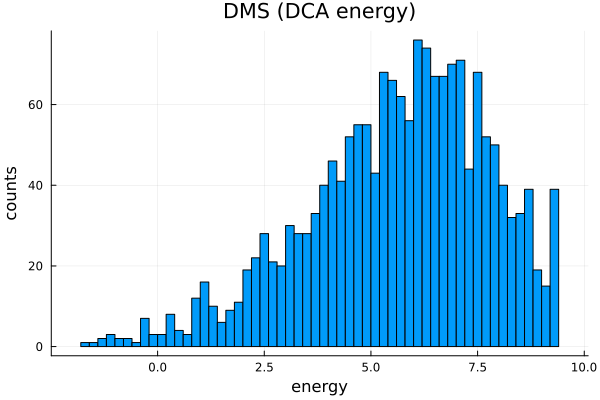

In [114]:
histogram(dms_E, bins=100, title= "DMS (DCA energy)", xlabel="energy", ylabel="counts", label=:false)

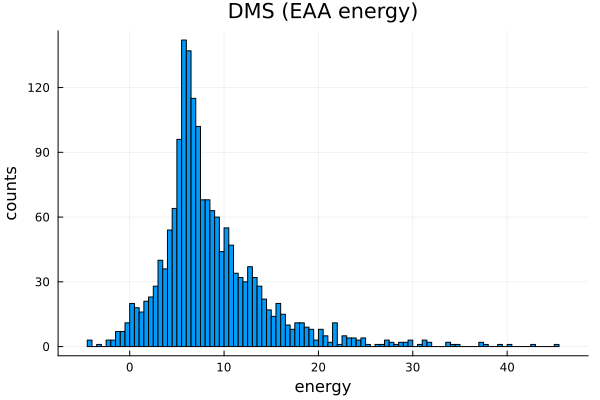

In [115]:
histogram(dms_model_energy, bins=100, title= "DMS (EAA energy)", xlabel="energy", ylabel="counts", label=:false)

In [116]:
scatter(dms_E, dms_model_energy, alpha=0.5, title= "DMS (DCA vs EAA)", xlabel="DCA energy", ylabel="EAA counts", label=:false)
x = [1,5,8]
y = x
plot!(x, y, label= "y=x")
savefig(joinpath(path, "scatter_energy_DCA_vs_EAA_no_reg.png"));

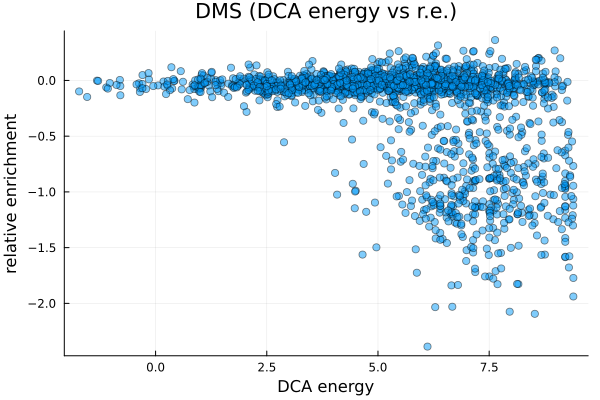

In [117]:
scatter(dms_E, dms_re, alpha=0.5, title= "DMS (DCA energy vs r.e.)", xlabel="DCA energy", ylabel="relative enrichment", label=:false)

In [118]:
scatter(dms_model_energy, dms_re, alpha=0.5, title= "DMS (EAA energy vs r.e.)", xlabel="EAA energy", ylabel="relative enrichment", label=:false)
savefig(joinpath(path, "scatter_energy_EAA_vs_RE_no_reg.png"));

# EAA couplings and fields histograms

In [119]:
histogram(vec(couplings_model)[vec(couplings_model).!=0], title= "Jij (E.A.A.)", xlabel="J_ij", ylabel="counts", label=:false, bins = 50)
savefig(joinpath(path, "Jij_no_reg.png"));

In [120]:
histogram(fields_model, title= "hi (E.A.A.)", xlabel="h_i", ylabel="counts", label=:false, bins = 40)
savefig(joinpath(path, "hi_no_reg.png"));

## Tests on Deep Mutational Scanning dataset

In [121]:
MSA_dms, dms_ave_energies = mutation_MSA(q, wt_seq, fields_model, couplings_model);

In [122]:
MSA_dms, profile_dms_ave_energies = mutation_MSA(q, wt_seq, fields_model, 0 .*couplings_model);

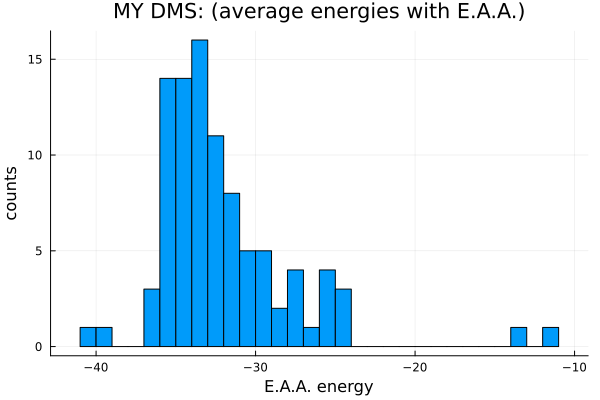

In [123]:
histogram(dms_ave_energies, title= "MY DMS: (average energies with E.A.A.)", xlabel="E.A.A. energy", ylabel="counts", label=:false, bins = 40)

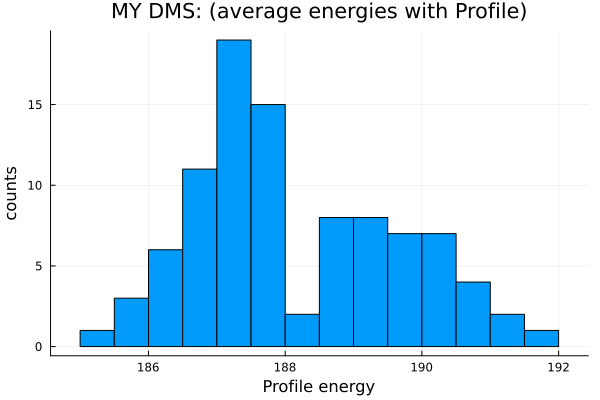

In [124]:
histogram(profile_dms_ave_energies, title= "MY DMS: (average energies with Profile)", xlabel="Profile energy", ylabel="counts", label=:false, bins = 20)

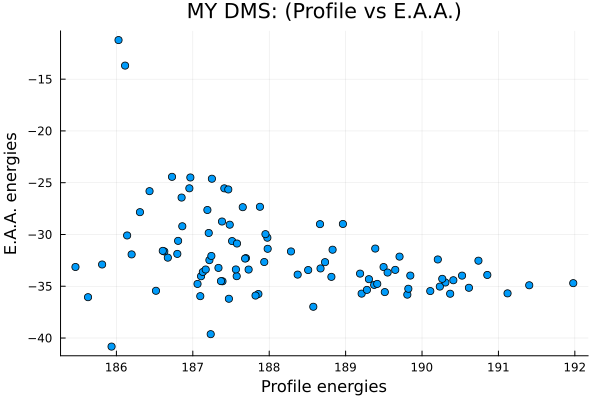

In [125]:
scatter(profile_dms_ave_energies, dms_ave_energies, title= "MY DMS: (Profile vs E.A.A.)", xlabel="Profile energies", ylabel="E.A.A. energies", label=:false,)

In [126]:
giv_DMS_prof_energies = compute_dms_ave_energies(q, dms_MSA, wt_seq, fields_model, 0 .* couplings_model);

In [127]:
histogram(giv_DMS_prof_energies, title= "GIVEN DMS: (average energies with Profile)", xlabel="Profile energies", ylabel="counts", label=:false, bins = 20)
savefig(joinpath(path, "profile_hist_no_reg.png"));

In [128]:
giv_DMS_EAA_energies = compute_dms_ave_energies(q, dms_MSA, wt_seq, fields_model, couplings_model);

In [129]:
histogram(giv_DMS_EAA_energies, title="GIVEN DMS: (average energies with E.A.A.)", xlabel="E.A.A. energies", ylabel="counts", label=:false, bins = 27)
savefig(joinpath(path, "EAA_hist_no_reg.png"));

In [130]:
giv_MSA_martin_energies = martin_compute_dms_ave_energies(q, dms_MSA, wt_seq, dms_E);

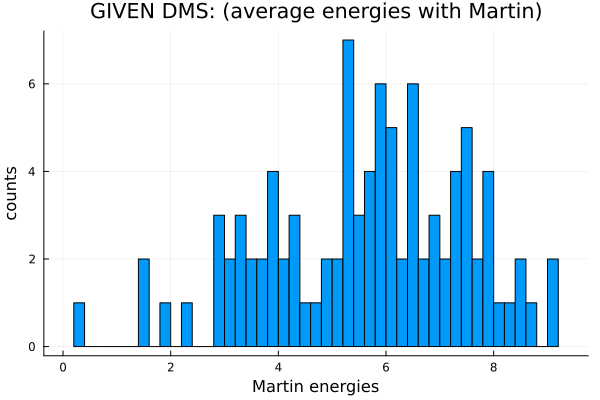

In [131]:
histogram(giv_MSA_martin_energies, title = "GIVEN DMS: (average energies with Martin)", xlabel="Martin energies", ylabel="counts", label=:false, bins = 50)

In [132]:
# correlations
print("Correlations over the GENERATED dataset \n")
print("DCA vs EAA: Pearson(E_DCA,E_EAA): ", cor(giv_MSA_martin_energies, giv_DMS_EAA_energies), ";   Spearman(E_DCA,E_EAA): ", corspearman(Float64.(giv_MSA_martin_energies),Float64.(giv_DMS_EAA_energies)),";\n")

Correlations over the GENERATED dataset 
DCA vs EAA: Pearson(E_DCA,E_EAA): 0.3220482968208607;   Spearman(E_DCA,E_EAA): 0.24639670555936857;


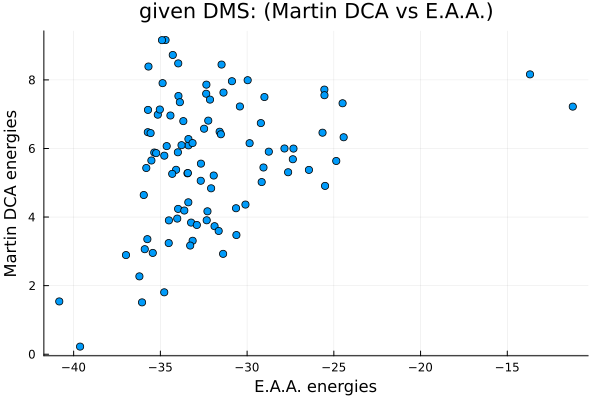

In [133]:
scatter(giv_DMS_EAA_energies, giv_MSA_martin_energies, title= "given DMS: (Martin DCA vs E.A.A.)", xlabel="E.A.A. energies", ylabel="Martin DCA energies", label=:false,)

In [134]:
fields_model_03 = JLD.load("parameters/h_0.3.jld")["data"]
couplings_model_03 = JLD.load("parameters/Jij_0.3.jld")["data"];

fields_model_04 = JLD.load("parameters/h_0.4.jld")["data"]
couplings_model_04 = JLD.load("parameters/Jij_0.4.jld")["data"];

fields_model_05 = JLD.load("parameters/h_0.5.jld")["data"]
couplings_model_05 = JLD.load("parameters/Jij_0.5.jld")["data"];

fields_model_06 = JLD.load("parameters/h_0.6.jld")["data"]
couplings_model_06 = JLD.load("parameters/Jij_0.6.jld")["data"];

fields_model_07 = JLD.load("parameters/h_0.7.jld")["data"]
couplings_model_07 = JLD.load("parameters/Jij_0.7.jld")["data"];

fields_model_08 = JLD.load("parameters/h_0.8.jld")["data"]
couplings_model_08 = JLD.load("parameters/Jij_0.8.jld")["data"];

fields_model_09 = JLD.load("parameters/h_0.8.jld")["data"]
couplings_model_09 = JLD.load("parameters/Jij_0.8.jld")["data"];

fields_model_095 = JLD.load("parameters/h_0.3_stop90_reg.jld")["data"]
couplings_model_095 = JLD.load("parameters/Jij_0.3_stop90_reg.jld")["data"];

In [135]:
full_energies_03 = compute_dms_ave_energies(q, dms_MSA, wt_seq, fields_model_03, couplings_model_03);
full_energies_04 = compute_dms_ave_energies(q, dms_MSA, wt_seq, fields_model_04, couplings_model_04);
full_energies_05 = compute_dms_ave_energies(q, dms_MSA, wt_seq, fields_model_05, couplings_model_05);
full_energies_06 = compute_dms_ave_energies(q, dms_MSA, wt_seq, fields_model_06, couplings_model_06);
full_energies_07 = compute_dms_ave_energies(q, dms_MSA, wt_seq, fields_model_07, couplings_model_07);
full_energies_08 = compute_dms_ave_energies(q, dms_MSA, wt_seq, fields_model_08, couplings_model_08);
full_energies_09 = compute_dms_ave_energies(q, dms_MSA, wt_seq, fields_model_08, couplings_model_08);
full_energies_095 = compute_dms_ave_energies(q, dms_MSA, wt_seq, fields_model_095, couplings_model_095);

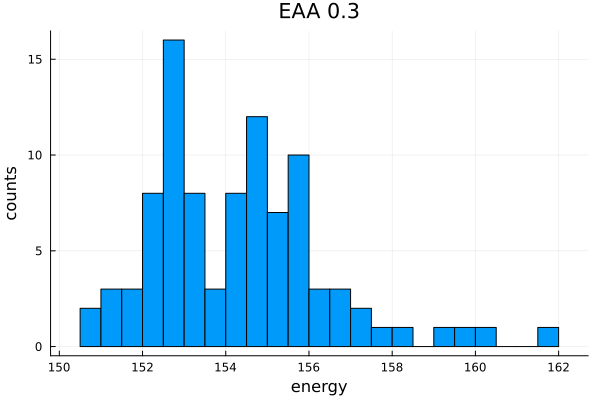

In [136]:
histogram(full_energies_03, title= "EAA 0.3", xlabel="energy", ylabel="counts", label=:false, bins = 30)

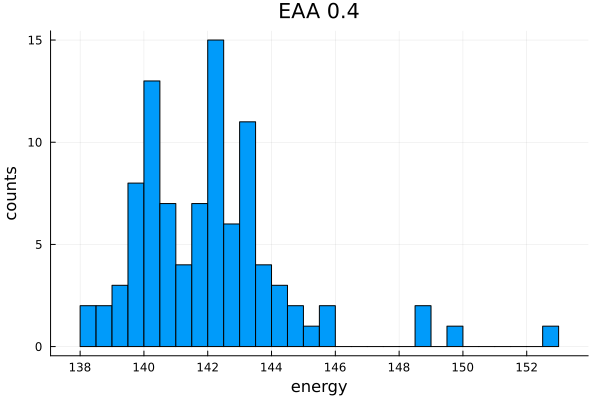

In [137]:
histogram(full_energies_04, title= "EAA 0.4", xlabel="energy", ylabel="counts", label=:false, bins = 30)

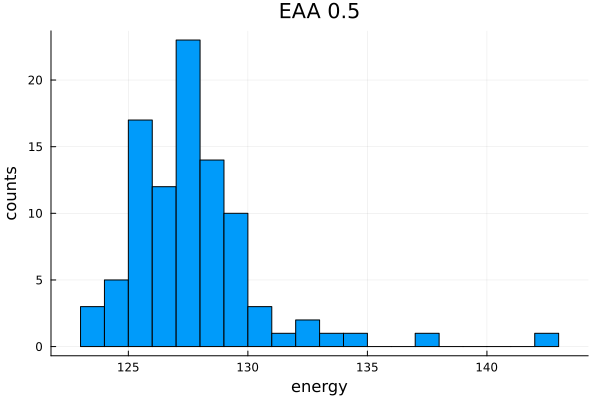

In [138]:
histogram(full_energies_05, title= "EAA 0.5", xlabel="energy", ylabel="counts", label=:false, bins = 30)

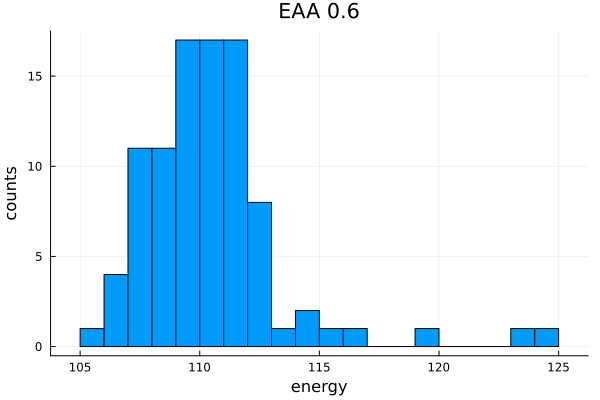

In [139]:
histogram(full_energies_06, title= "EAA 0.6", xlabel="energy", ylabel="counts", label=:false, bins = 30)

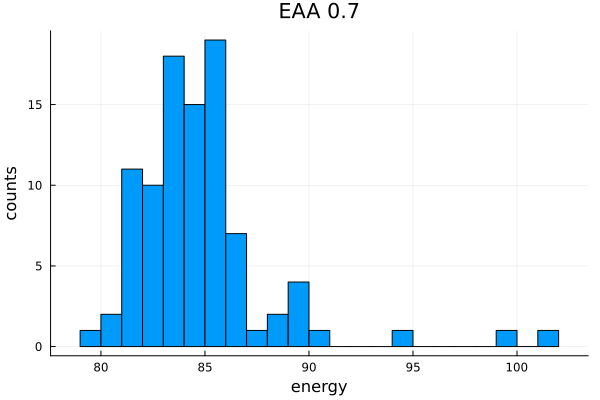

In [140]:
histogram(full_energies_07, title= "EAA 0.7", xlabel="energy", ylabel="counts", label=:false, bins = 30)

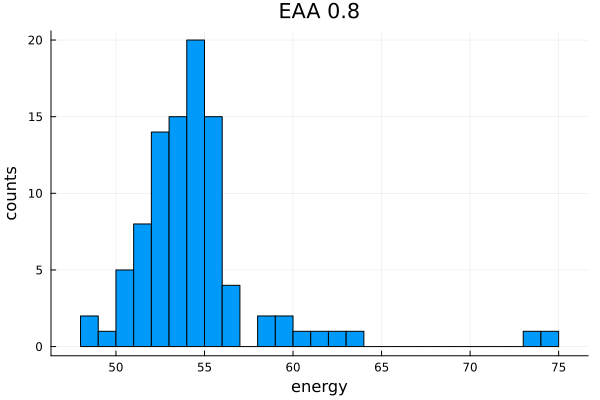

In [141]:
histogram(full_energies_08, title= "EAA 0.8", xlabel="energy", ylabel="counts", label=:false, bins = 30)

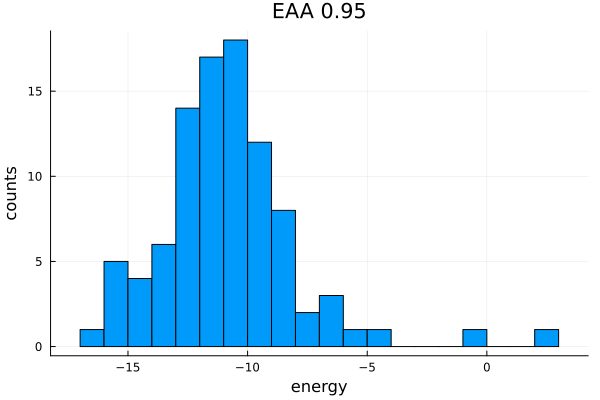

In [142]:
histogram(full_energies_095, title= "EAA 0.95", xlabel="energy", ylabel="counts", label=:false, bins = 30)

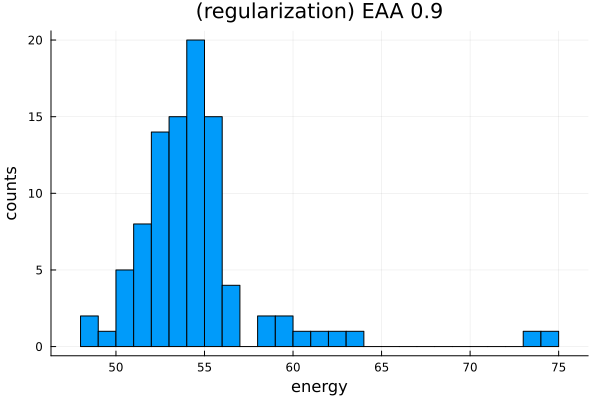

In [143]:
# with regularization
histogram(full_energies_09, title= "(regularization) EAA 0.9", xlabel="energy", ylabel="counts", label=:false, bins = 30)

## Energy-Energy and Energy-Fitness correlation for different pseudo-counts

In [2]:
using XLSX
using Plots
using JLD

include("../src/FCSeqTools.jl");
include("../src/functions.jl");

In [3]:
# READING MARTIN'S DATA ###################################################################
nat_MSA, nat_re, nat_E = read_fasta("paper_data/nat.faa", 0.2);
gen_MSA, gen_re, gen_E = read_fasta("paper_data/gen.faa", 0.2);
dms_MSA, dms_re, dms_E = read_fasta("paper_data/dms.faa", 0.2);

L_nat = length(nat_MSA[:,1])
L_gen = length(gen_MSA[:,1])
L_dms = length(dms_MSA[:,1]);

# SELECT OUR DATA #########################################################################
alignment = "CM_alignment"   # "Betalactamases"  
sigla =  "(CM)"    # "(BL)"                                         
method = "cumulative"
test = "main_test"
stop = 0.9
fraction = 0.3
alphas = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]#, 0.95]
l = length(alphas)
nbk = 1
threshold = 0
α_h = 0.01 # initial pseudo count
#########################################################################################
q = 21
sigla == "(CM)"  ? L = 96 : L = 222
sigla == "(CM)"  ? MSA = "CM_130530_MC.fasta" : MSA = "Betalactamases_VIM-NDM.fasta"
#########################################################################################

#rm(joinpath("figures/"* alignment * "/context.dep.Entropy_vs_pseudo-count"), force=true, recursive=true)
#mkdir(joinpath("figures/"* alignment * "/context.dep.Entropy_vs_pseudo-count"))
#figure_path = joinpath("figures/"* alignment * "/context.dep.Entropy_vs_pseudo-count");